In [1]:
%pylab inline

import gc
import fpfs
import numpy as np
from fpfs import simutil
import scipy.ndimage as ndi
import matplotlib.pylab as plt
import astropy.io.fits as pyfits
from fpfs.imgutil import gauss_kernel
import sys
sys.path.insert(1, 'run')
import pdet

Populating the interactive namespace from numpy and matplotlib
Do not have lsst pipeline!


In [12]:
ishear=1
igroup=0
do_plot=False
ngrid=64
if igroup>=0:
    ngal=100
    img1=pyfits.getdata('../../FPFS2/sim/galaxy_basicCenter_psf60/image-%d-g%d-0000.fits' %(igroup,ishear))
    img2=pyfits.getdata('../../FPFS2/sim/galaxy_basicCenter_psf60/image-%d-g%d-2222.fits' %(igroup,ishear))
else:
    ngal=10
    img1=simutil.make_basic_sim('basicCenter_psf60','g%d-0000' %ishear,0,ny=ngal,nx=ngal,do_write=False)
    img2=simutil.make_basic_sim('basicCenter_psf60','g%d-2222' %ishear,0,ny=ngal,nx=ngal,do_write=False)
ngrid2=ngrid*ngal

# PSF
psf=pyfits.getdata('../../FPFS2/sim/galaxy_basic_psf60/psf-60.fits')
npad       =   (ngrid2-psf.shape[0])//2
psfData    =   np.pad(psf,(npad+1,npad),mode='constant')
assert psfData.shape[0]==ngrid2
psfF=np.fft.fft2(np.fft.ifftshift(psfData))
gsigma=3.*2.*np.pi/64
x   = np.fft.fftfreq(ngrid2,1/np.pi/2.)

gKer,grids=gauss_kernel(ngrid2,ngrid2,gsigma,return_grid=True)
k2grid,k1grid=grids

imgF1=np.fft.fft2(img1)/psfF*gKer
imgF2=np.fft.fft2(img2)/psfF*gKer
imgCov1=np.fft.ifft2(imgF1).real
imgCov2=np.fft.ifft2(imgF2).real
gc.collect()

9887

In [13]:
npixt = 1
sizet = 1 + 2 * npixt

footprint = np.zeros((sizet, sizet))
footprint[npixt, npixt] = 1.
footprint[npixt+1, npixt] = -1.
imgCovACov1=ndi.convolve(imgCov1,footprint,mode='constant')
gc.collect()

23

In [14]:
thres=1.*np.sqrt(4e-3)
indX=np.arange(32,ngal*64,64)
indY=np.arange(32,ngal*64,64)
inds=np.meshgrid(indY,indX,indexing='ij')

In [15]:
if True:
    coords   = np.array(np.zeros(inds[0].size),dtype=[('pdet_y','i4'),('pdet_x','i4')])
    coords['pdet_y']=np.ravel(inds[0])
    coords['pdet_x']=np.ravel(inds[1])
else:
    coords=pdet.detect_coords(imgCov1,thres)

10000


25

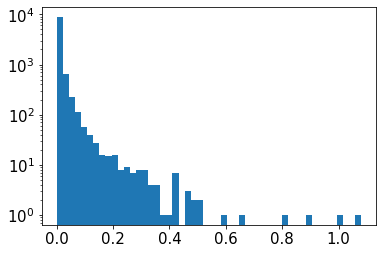

In [16]:
print(len(coords))
plt.close()
plt.hist(imgCovACov1[coords['pdet_y'],coords['pdet_x']],bins=50)
plt.yscale('log')
gc.collect()

12475

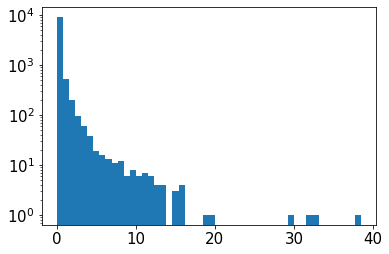

In [17]:
plt.close()
plt.hist(imgCov1[coords['pdet_y'],coords['pdet_x']],bins=50)
plt.yscale('log')
gc.collect()

In [20]:
out1=pdet.get_shear_response(img1,psfData,gsigma=6*2*np.pi/64,coords=coords)
out2=pdet.get_shear_response(img2,psfData,gsigma=6*2*np.pi/64,coords=coords)

In [21]:
for j in range(1,4):
    for i in range(1,4):
        print(j,i)
        resEst=(out2['pdet_v%d%d' %(j,i)]-out1['pdet_v%d%d'%(j,i)])/0.04
        res=(out2['pdet_v%d%dr%d'%(j,i,ishear)]+out1['pdet_v%d%dr%d'%(j,i,ishear)])/2.
        print(np.average((res-resEst)/np.abs(resEst)),np.argmax(np.abs((res-resEst)/resEst)))
        print(np.abs((res-resEst)/resEst))
        break

1 1
4.376968682417121e-05 6345
[0.0019717  0.00058608 0.00072386 ... 0.00103501 0.00061758 0.00089157]
2 1
0.0013431791350987867 1857
[0.00127664 0.0002623  0.00063356 ... 0.00144484 0.00058407 0.000665  ]
3 1
-2.3138129169392546e-05 7903
[0.00268173 0.00035459 0.00061597 ... 0.00101553 0.00068214 0.00063861]


In [2]:
import fitsio
import numpy.lib.recfunctions as rfn

out1=[]
out2=[]
for _i in range(128):
    _a1=fitsio.read('../sim/outBasic-var0em0/psf60/fpfs-cut16-%04d-g1-0000.fits' %_i)
    _a2=fitsio.read('../sim/outBasic-var0em0/psf60/fpfs-cut16-%04d-g1-2222.fits' %_i)
    out1.append(_a1)
    out2.append(_a2)
out1 =   rfn.stack_arrays(out1,usemask=False)
out2 =   rfn.stack_arrays(out2,usemask=False)
    
gc.collect()

6

In [3]:
ell1=fpfs.fpfsBase.fpfsM2E(out1,const=100)
ell2=fpfs.fpfsBase.fpfsM2E(out2,const=100)

In [4]:
y1=[]
y2=[]
for i in range(0,10):
    msk1=out1['pdet_v22']>0.2*i
    msk2=out2['pdet_v22']>0.2*i
    msks1=(out1['pdet_v22']>0.2*i)&(out1['pdet_v22']<0.2*i+0.02)
    msks2=(out2['pdet_v22']>0.2*i)&(out2['pdet_v22']<0.2*i+0.02)
    if np.sum(msks1)==0:
        cor1=0.
    else:
        cor1=np.sum(ell1[msks1]['fpfs_e1']*out1[msks1]['pdet_v22r1'])/0.02
    if np.sum(msks2)==0:
        cor2=0.
    else:
        cor2=np.sum(ell2[msks2]['fpfs_e1']*out2[msks2]['pdet_v22r1'])/0.02
        
    de=np.sum(ell2[msk2]['fpfs_e1'])-np.sum(ell1[msk1]['fpfs_e1'])
    rave=(np.sum(ell2[msk2]['fpfs_RE'])+np.sum(ell1[msk1]['fpfs_RE']))/2.
    raveR=(np.sum(ell2[msk2]['fpfs_RE'])+np.sum(ell1[msk1]['fpfs_RE'])+cor1+cor2)/2.
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    del msk1,msk2,msks1,msks2
gc.collect()

0

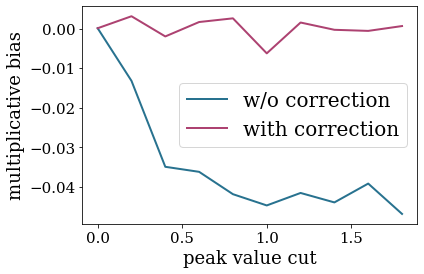

In [6]:
import pltutil
cuts=np.arange(0,2,0.2)

plt.plot(cuts,np.array(y1),label='w/o correction',color=pltutil.colors[0])
plt.plot(cuts,np.array(y2),label='with correction',color=pltutil.colors[1])
plt.xlabel('peak value cut')
plt.ylabel('multiplicative bias')
plt.legend()

Text(0, 0.5, 'number')

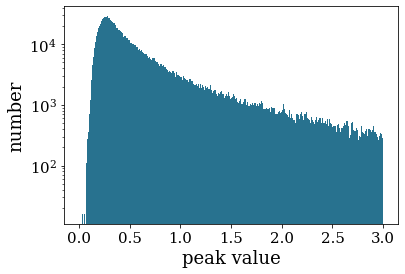

In [7]:
plt.close()
plt.hist(out1['pdet_v22'],range=(0,3),bins=300,color=pltutil.colors[0])
plt.yscale('log')
plt.xlabel('peak value')
plt.ylabel('number')
